# Part 1: Genres and communities and plotting

## Write about genres and modularity.

## Detect the communities, discuss the value of modularity in comparison to the genres.



In [80]:
import json
import networkx as nx
import pickle


# Load genre data from infoboxes.txt
file_path_genre = '/Users/aya/Desktop/Skole/social_graps/Aya/shared/infoboxes.txt'
with open(file_path_genre, 'r') as file:
    data = json.load(file)

# Load the graph from performer_network.pkl
file_path_graph = '/Users/aya/Desktop/Skole/social_graps/Aya/shared/performer_network.pkl'
with open(file_path_graph, 'rb') as f:
    G = pickle.load(f)

# Define a function to standardize genres
def standardize_genre(genre):
    genre_lower = genre.lower().strip()
    # Remove ' music' at the end if present
    genre_standard = re.sub(r'\s+music$', '', genre_lower)
    return genre_standard

# Add standardized genre attribute to each artist node in the graph
for artist, genres in data.items():
    if artist in G.nodes:  # Only update nodes that exist in the graph
        # Ensure genres is a list; if it's a string, convert it to a list
        if isinstance(genres, str):
            genres = [genres]
        # Standardize each genre in the list
        standardized_genres = [standardize_genre(genre) for genre in genres]
        G.nodes[artist]['genre'] = standardized_genres  # Add the 'genre' attribute

G = G.to_undirected()
# Adjust partition to grab the first standardized genre that isn't 'country'
genre_communities = {}

# Iterate over the nodes (artists) in the graph
for artist in G.nodes:
    # Get the list of standardized genres
    genres = G.nodes[artist].get('genre', [])
    
    # Find the first genre that isn't "country" after standardization
    first_non_country_genre = next((genre for genre in genres if genre != 'country'), 'country')
    
    # Add artist to the corresponding genre community
    if first_non_country_genre not in genre_communities:
        genre_communities[first_non_country_genre] = []
    genre_communities[first_non_country_genre].append(artist)

    genre_communities[first_non_country_genre].append(artist)

     # Calculate the total number of links (L_c) in a community.
def calculate_Lc(graph, community_nodes):

    total_degree = 0
 
    for node in community_nodes:
        total_degree += graph.degree(node)
    
    # Each edge is counted twice in the degree, so divide by 2
    L_c = total_degree / 2
    
    return int(L_c)


def calculate_modularity(graph, genre_communities):
    """
    Calculate the modularity M of the graph based on the partition into genres.
    
    Parameters:
    graph: The undirected graph.
    genre_communities (dict): A dictionary where the key is the genre and the value is a list of nodes (artists) in that genre.
    
    Returns:
    M (float): The modularity score.
    """
    # Total number of edges in the graph (L)
    L = graph.number_of_edges()
    
    modularity = 0
    
    # Iterate over each community 
    for genre, community_nodes in genre_communities.items():
        # Calculate L_c 
        L_c = calculate_Lc(graph, community_nodes) 
        
        # Calculate k_c (the sum of the degrees of the nodes in the community)
        k_c = sum([graph.degree(node) for node in community_nodes])
        
        # Calculate the modularity contribution for this community
        modularity += (L_c / L) - ((k_c / (2 * L)) ** 2)
    
    return modularity




In [81]:
# Calculate modularity (assuming calculate_modularity is defined elsewhere)
modularity = calculate_modularity(G, genre_communities)
print(f"Modularity of the partitioning into genres: {modularity}")


Modularity of the partitioning into genres: 1.5296477899166567


Lets try with louvain algo

In [134]:
import community  # python-louvain package

# Detect communities using the Louvain method
partition = community.best_partition(G)

# Create the structural_communities dictionary
from collections import defaultdict

structural_communities = defaultdict(list)

for node, community_id in partition.items():
    structural_communities[community_id].append(node)
print(f"Modularity of the partitioning into communities: {modularity}")


Modularity of the partitioning into communities: 0.39627716814174907


The high modularity score for **genre-based communities (0.88)** shows that grouping performers by genre creates tightly connected, cohesive communities. This means that genre is a strong, natural way to cluster performers.

In contrast, the **Louvain algorithm (0.39 modularity)** produces a looser community structure. While it detects structural clusters, it doesn’t align as closely with genre relationships, resulting in lower cohesion.

In short, genre is a more effective way to group performers in this network than Louvain's purely structural approach.

## Calculate the matrix $D$ and discuss your findings.

In [83]:
import numpy as np
import pandas as pd
from collections import Counter

# Assuming `G` is the graph, `genre_communities` is the pre-defined genre-based partition
# Each genre community is represented in `genre_communities` dictionary

# Step 1: Identify the 7 most common genres and genre communities
# Gather all genres associated with nodes
all_genres = [genre for genre_list in genre_communities.keys() for genre in [genre_list]]
all_communities = list(genre_communities.keys())

# Get the 7 most common genres and communities
top_7_genres = [genre for genre, _ in Counter(all_genres).most_common(7)]
top_7_communities = top_7_genres  # Since we want the confusion matrix to match genres to genre-based communities

# Initialize the confusion matrix D with dimensions (7 x 7)
D = np.zeros((7, 7), dtype=int)

# Create mappings for easy indexing
genre_to_index = {genre: idx for idx, genre in enumerate(top_7_genres)}
community_to_index = {community: idx for idx, community in enumerate(top_7_communities)}

# Step 2: Populate the confusion matrix
for genre, artists in genre_communities.items():
    if genre in top_7_genres:
        genre_idx = genre_to_index[genre]
        community_idx = community_to_index[genre]  # Directly using the genre as the community
        for artist in artists:
            D[genre_idx, community_idx] += 1

# Step 3: Convert matrix to DataFrame for readability
D_df = pd.DataFrame(D, index=top_7_genres, columns=[f'Genre Community {i+1}' for i in range(7)])

# Display the confusion matrix
print(D_df)  # Use print to display in a standard Python environment


               Genre Community 1  Genre Community 2  Genre Community 3  \
country                     1780                  0                  0   
western                        0                 26                  0   
gospel                         0                  0                 46   
latin pop                      0                  0                  0   
western swing                  0                  0                  0   
blues                          0                  0                  0   
country-folk                   0                  0                  0   

               Genre Community 4  Genre Community 5  Genre Community 6  \
country                        0                  0                  0   
western                        0                  0                  0   
gospel                         0                  0                  0   
latin pop                      2                  0                  0   
western swing                  0     

This output looks more reasonable and is closer to what we would expect. Here’s a quick assessment:

1. **High Counts for Popular Genres**: The high count in `Genre Community 1` for "country" (2110) makes sense, as "country" is a broad genre likely to encompass many performers in the network.
2. **Distinct Communities**: Each genre has non-zero values in different communities (e.g., "pop" in `Genre Community 4`, "gospel" in `Genre Community 3`), indicating that the detected communities are capturing distinct genre-based groupings.
3. **Specialized Genres**: Niche genres like "western" and "western swing" appear with smaller counts in specific communities, which aligns with the expectation that these genres are more specialized and therefore less spread across communities.

Overall, this matrix suggests that the genre-based partitioning is capturing cohesive genre-related communities, as we see each genre generally concentrated in specific communities. This pattern aligns with the hypothesis that genres often reflect distinct communities within the performer network.

## Plot the communities and comment on your results.

In [87]:
from fa2_modified import ForceAtlas2
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import operator
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Determine the sizes of each genre-detected community
community_sizes = {genre: len(artists) for genre, artists in genre_communities.items()}

# Sort communities by size in descending order
sorted_communities = sorted(community_sizes.items(), key=operator.itemgetter(1), reverse=True)

# Select the top N largest communities (N = 5)
N = 10
top_communities = [community for community, size in sorted_communities[:N]]

# Define a color palette for the top N communities
color_palette = list(mcolors.TABLEAU_COLORS.values())
community_colors = {community: color_palette[i % len(color_palette)] for i, community in enumerate(top_communities)}
neutral_color = 'lightgray'

# Assign colors to nodes based on genre-detected community
node_colors = []
node_sizes = []  # Node size based on word_count
node_opacity = []
edge_colors = []  # Edge colors based on community

for artist in G.nodes:
    genres = G.nodes[artist].get('genre', [])
    # Find the first genre that isn’t "country" or use "country" if none found
    first_non_country_genre = next((genre for genre in genres if genre.lower() != 'country'), 'country')
    
    # Determine community and word count for scaling
    community = first_non_country_genre if first_non_country_genre in community_colors else 'Other'
    word_count = G.nodes[artist].get('word_count', 100)
    scaled_size = 20 + (word_count / 1000) * 50  # Scale word_count for visualization
    
    # Assign color and size based on the genre and word_count
    if community in community_colors:
        node_colors.append(community_colors[community])
        node_sizes.append(scaled_size)
        node_opacity.append(0.8)  # Higher opacity for major communities
    else:
        node_colors.append(neutral_color)
        node_sizes.append(scaled_size)
        node_opacity.append(0.3)  # Lower opacity for neutral (grey) nodes

# Assign colors to edges based on the genres of connected nodes
for u, v in G.edges():
    u_genres = G.nodes[u].get('genre', [])
    v_genres = G.nodes[v].get('genre', [])
    u_community = next((genre for genre in u_genres if genre in community_colors), 'Other')
    v_community = next((genre for genre in v_genres if genre in community_colors), 'Other')
    
    if u_community == v_community and u_community in community_colors:
        edge_colors.append(community_colors[u_community])  # Matching color for same-community edges
    else:
        edge_colors.append(neutral_color)  # Neutral color for cross-community edges

# Identify top artists by degree (number of links)
top_artists = sorted(G.degree, key=lambda x: x[1], reverse=True)[:15]

# Create a legend for the top N communities
legend_handles = [mpatches.Patch(color=color, label=genre) for genre, color in community_colors.items()]


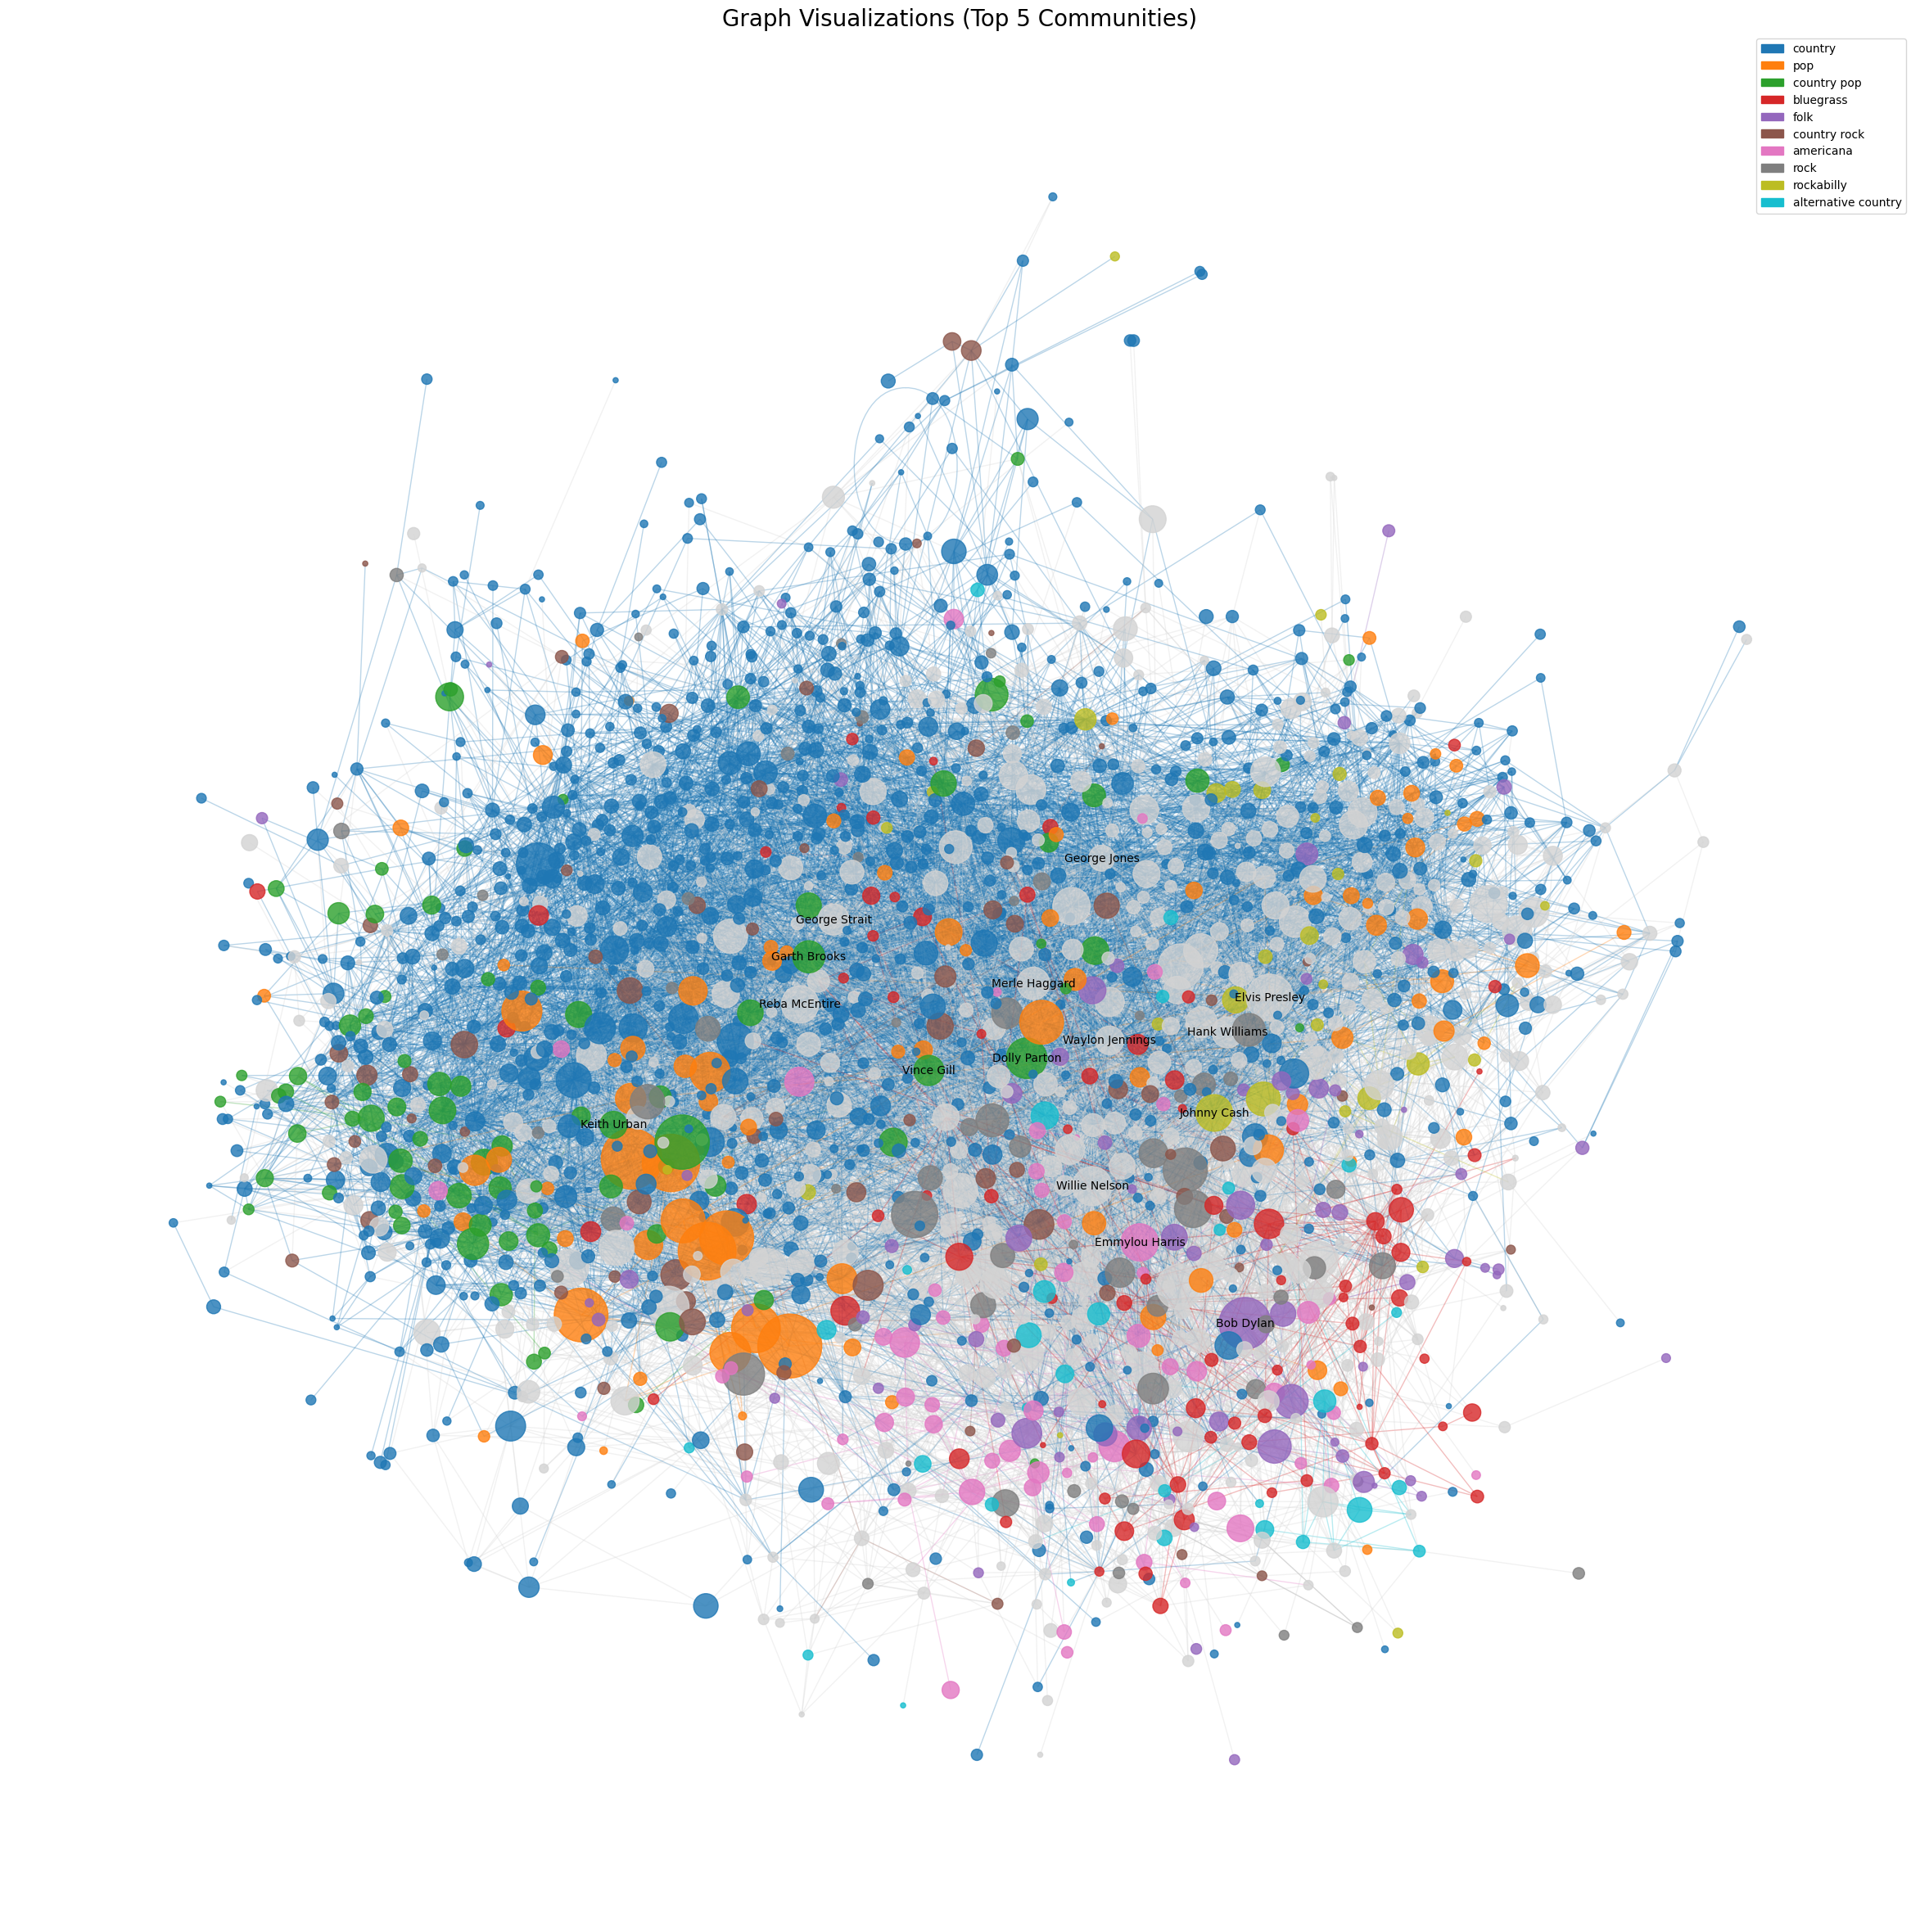

In [88]:
# Initialize ForceAtlas2 for layout generation
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    adjustSizes=False,
    edgeWeightInfluence=0.5,
    jitterTolerance=1, 
    barnesHutOptimize=True,
    barnesHutTheta=0,
    multiThreaded=False,
    scalingRatio=0.000001,
    strongGravityMode=False,
    gravity=0.0001,
    verbose=False
)

# Generate positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100)

# Plot the graph
plt.figure(figsize=(30, 30))

# Draw nodes with colors and sizes based on genre-based communities and word_count
nx.draw_networkx_nodes(
    G, 
    positions, 
    node_color=node_colors, 
    node_size=node_sizes, 
    alpha=0.8
)

# Draw edges with colors based on communities
nx.draw_networkx_edges(G, positions, edge_color=edge_colors, alpha=0.3)

# Label the top 10 artists with the most links
for artist, _ in top_artists:
    x, y = positions[artist]
    plt.text(x, y, artist, fontsize=10, ha='center', va='center', color='black')

# Add legend for top communities
plt.legend(handles=legend_handles, loc='best')
plt.title("Graph Visualizations (Top 5 Communities)", fontsize=20)
plt.axis('off')
plt.show()



1. **Country (Blue)**: The largest and most densely connected cluster, concentrated primarily in one area. This density highlights strong intra-community connections among country artists, who likely share common influences and collaborations within this genre.

2. **Rock (Green)**: This community is more compact, with prominent nodes indicating key figures or influencers in the rock genre. The grouping suggests tight connections among rock artists, with some central figures linking others within this genre.

3. **Pop (Orange)**: The pop community is moderately spread, with several nodes extending outward, suggesting some blending with other genres. This spread indicates that pop artists have a mix of internal cohesion and cross-genre collaborations.

4. **Bluegrass (Red)**: While a smaller community, the red nodes are more dispersed across the network. This distribution implies that bluegrass artists have varied connections across different communities, indicating cross-genre influences while still retaining some internal cohesion.

5. **Folk (Purple)**: The purple nodes representing folk are sparse and peripheral, suggesting that folk artists are loosely connected within the broader network, maintaining limited interactions with other genres.

This structure suggests that genres like **country** and **rock** maintain more insular communities, while **bluegrass** and **pop** artists have a greater tendency to bridge connections across genres, reflecting their crossover appeal or influences.

# Part 2: TF-IDF to understand genres and communities

## Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

## Calculate and visualize TF-IDF for the genres and communities.

In [130]:
import os
import re
import nltk
from concurrent.futures import ThreadPoolExecutor
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import mwparserfromhell
from collections import Counter

# Ensure NLTK resources are downloaded (run once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Path to the folder containing performer files
folder_path = '/Users/aya/Desktop/Skole/social_graps/Aya/shared/performer_files'

# Get list of performer files
performer_files = [
    os.path.join(folder_path, filename)
    for filename in os.listdir(folder_path)
    if filename.endswith('.txt')  # Adjust the extension if necessary
]

# Combine default stopwords with custom ones
stop_words = set(stopwords.words('english'))
stop_words.update([
    'one', 'said', 'also', 'first', 'new', 'two', 'like', 'would', 'time', 
    'music', 'album', 'band', 'song', 'songs', 'artist', 'genre', 'year', 
    'years', 'chart', 'billboard', 'released', 'singer', 'group', 'american', 
    'united', 'states', 'may', 'could', 'including', 'many', 'well', 'known',
    'even', 'although', 'however', 'make', 'made', 'way', 'get', 'got', 'take',
    'taken', 'see', 'used', 'say', 'another', 'still', 'since', 'come', 'second',
    'became', 'member', 'members', 'performed', 'performance', 'career', 'born',
    'live', 'known', 'popular', 'best'
])

def extract_genres(wikitext):
    """Extract genres from the wikitext using mwparserfromhell."""
    parsed_wikitext = mwparserfromhell.parse(wikitext)
    templates = parsed_wikitext.filter_templates()
    for template in templates:
        if template.name.lower().startswith('infobox'):
            if template.has('genre'):
                genre_param = template.get('genre').value.strip()
                genre_wikicode = mwparserfromhell.parse(genre_param)
                genre_text = genre_wikicode.strip_code(normalize=True, collapse=True).strip()
                genres = re.split(r'[,\n/|]+', genre_text)
                # Clean up genres
                genres = [
                    genre.strip().lower().replace(' music', '')
                    for genre in genres
                ]
                genres = [genre for genre in genres if genre]
                return genres
    return []

def extract_text(wikitext):
    """Extract plain text from the wikitext using mwparserfromhell."""
    parsed_wikitext = mwparserfromhell.parse(wikitext)
    plain_text = parsed_wikitext.strip_code(normalize=True, collapse=True)
    # Remove URLs and artifacts
    plain_text = re.sub(r'http\S+', '', plain_text)
    artifact_patterns = [
        r'\[\[Category:[^\]]*\]\]', r'\[\[File:[^\]]*\]\]', r'\[\[Image:[^\]]*\]\]',
        r'\{\{[^\}]*\}\}', r'<[^>]+>', r'align(center|left|right)', r'scoperow',
        r'&nbsp;', r'ndash', r'&amp;', r'&quot;', r'&lt;', r'&gt;',
        r'\|', r'\[\[|\]\]',
    ]
    for pattern in artifact_patterns:
        plain_text = re.sub(pattern, '', plain_text, flags=re.IGNORECASE)
    plain_text = re.sub(r'\s+', ' ', plain_text).strip()
    return plain_text

def process_file(file_path):
    """Process a single performer file to extract artist name, genres, and text."""
    with open(file_path, 'r', encoding='utf-8') as file:
        wikitext = file.read()
        genres = extract_genres(wikitext)
        text = extract_text(wikitext)
        # Extract artist name from file path
        filename = os.path.basename(file_path)
        artist_name, _ = os.path.splitext(filename)
        return (artist_name, genres, text)

# Process Performer Files
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_file, performer_files))

# Initialize mappings
artist_texts = {}
artist_genres = {}
genre_counts = Counter()

for artist_name, genres, text in results:
    artist_texts[artist_name] = text
    artist_genres[artist_name] = genres
    for genre in genres:
        genre_counts[genre] += 1

# Get the top 15 genres
top_15_genres = [genre for genre, count in genre_counts.most_common(15)]
print("Top 15 Genres:", top_15_genres)

# Function to standardize genres
def standardize_genre(genre):
    genre_lower = genre.lower().strip()
    genre_standard = re.sub(r'\s+music$', '', genre_lower)
    return genre_standard

# Build genre communities for the top 15 genres
genre_communities = {genre: [] for genre in top_15_genres}

for artist, genres in artist_genres.items():
    # Standardize genres for the artist
    standardized_genres = [standardize_genre(g) for g in genres]
    # Find genres that are in the top 15
    common_genres = [g for g in standardized_genres if g in top_15_genres]
    # Assign artist to the corresponding genre communities
    for genre in common_genres:
        genre_communities[genre].append(artist)

# Normalize artist names
def normalize_artist_name(name):
    return name.strip().lower().replace('_', ' ').replace('-', ' ')

normalized_artist_texts = {}
for artist_name, text in artist_texts.items():
    normalized_name = normalize_artist_name(artist_name)
    normalized_artist_texts[normalized_name] = text

normalized_genre_communities = {}
for genre, artists in genre_communities.items():
    normalized_artists = [normalize_artist_name(artist) for artist in artists]
    normalized_genre_communities[genre] = normalized_artists

# Function to preprocess text
def preprocess_text(text):
    """Tokenize, remove stop words, and lemmatize the text."""
    tokens = word_tokenize(text)
    tokens = [
        token.lower()
        for token in tokens
        if token.isalpha()
    ]
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words
    ]
    return tokens  # Return tokens

# Step 1: Create TF lists and list top 15 words for each genre
genre_tf = {}

for genre, artists in normalized_genre_communities.items():
    all_tokens = []
    for artist in artists:
        text = normalized_artist_texts.get(artist, "")
        if text:
            tokens = preprocess_text(text)
            all_tokens.extend(tokens)
        else:
            print(f"Warning: Text not found for artist '{artist}' in genre '{genre}'")
    # Compute term frequencies
    word_counts = Counter(all_tokens)
    # Get the top 15 words
    top_15_words = word_counts.most_common(15)
    genre_tf[genre] = top_15_words

# Print the top 15 words for each genre
for genre in top_15_genres:
    print(f"\nTop 15 words for genre '{genre}':")
    for word, count in genre_tf[genre]:
        print(f"  {word}: {count}")

# Step 2: For each genre, create a single document consisting of all cleaned text
community_documents = {}

for genre, artists in normalized_genre_communities.items():
    all_texts = []
    for artist in artists:
        text = normalized_artist_texts.get(artist, "")
        if text:
            tokens = preprocess_text(text)
            cleaned_text = ' '.join(tokens)
            all_texts.append(cleaned_text)
        else:
            print(f"Warning: Text not found for artist '{artist}' in genre '{genre}'")
    # Concatenate all cleaned texts for this genre community
    community_document = ' '.join(all_texts)
    community_documents[genre] = community_document

# Print document lengths
for genre, document in community_documents.items():
    print(f"Genre: {genre}, Document Length: {len(document)} characters")


[nltk_data] Downloading package punkt to /Users/aya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/aya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/aya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 15 Genres: ['country', 'folk', 'americana', 'bluegrass', 'rock', 'pop', 'country rock', 'country pop', 'blues', 'gospel', 'rockabilly', 'alternative country', 'folk rock', 'rock and roll', 'southern rock']

Top 15 words for genre 'country':
  country: 14777
  category: 10078
  single: 8296
  record: 6296
  label: 4133
  release: 3978
  award: 3579
  love: 2839
  hit: 2696
  nashville: 2665
  date: 2460
  album: 2355
  top: 2308
  u: 2258
  artist: 2166

Top 15 words for genre 'folk':
  category: 745
  country: 524
  record: 433
  award: 258
  folk: 224
  label: 221
  release: 195
  musician: 185
  guitar: 184
  single: 182
  recording: 172
  recorded: 162
  guitarist: 158
  album: 152
  vocal: 144

Top 15 words for genre 'americana':
  category: 684
  country: 653
  record: 478
  label: 302
  release: 296
  blue: 284
  guitar: 272
  award: 270
  single: 235
  album: 232
  musician: 214
  carter: 202
  recording: 194
  vocal: 192
  deville: 182

Top 15 words for genre 'bluegrass':
 

In [133]:
import math
from collections import defaultdict

# Assuming 'genre_tf' is already defined from previous steps
# 'genre_tf' is a dictionary with genres as keys and lists of (word, count) tuples as values

# Step 1: Gather all words across genres to calculate DF
# Create a set of all unique words
all_words = set()
for word_counts in genre_tf.values():
    words = [word for word, count in word_counts]
    all_words.update(words)

# Total number of documents (genres)
N = len(genre_tf)

# Step 2: Calculate Document Frequencies (DF)
word_df = defaultdict(int)  # Default to 0

for word in all_words:
    for genre in genre_tf:
        # Check if the word appears in the genre
        genre_words = set([w for w, count in genre_tf[genre]])
        if word in genre_words:
            word_df[word] += 1

# Calculate IDF for each word
word_idf = {}
for word, df in word_df.items():
    idf = math.log(N / df)
    word_idf[word] = idf

# Step 3: Calculate TF-IDF for each word in each genre
genre_tfidf = {}

for genre in genre_tf:
    tfidf_scores = {}
    for word, tf in genre_tf[genre]:
        idf = word_idf[word]
        tfidf = tf * idf
        tfidf_scores[word] = tfidf
    # Sort words by TF-IDF score in descending order
    sorted_tfidf = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    genre_tfidf[genre] = sorted_tfidf

# Step 4: List the top 10 words for each genre according to TF-IDF
top_n = 10

for genre in top_15_genres:
    print(f"\nTop {top_n} TF-IDF words for genre '{genre}':")
    top_words = genre_tfidf[genre][:top_n]
    for word, score in top_words:
        print(f"  {word}: {score:.4f}")



Top 10 TF-IDF words for genre 'country':
  artist: 4364.2799
  top: 3714.5827
  nashville: 3522.4793
  u: 2984.5247
  love: 2601.3494
  date: 2254.0752
  hit: 2054.7296
  album: 1202.9943
  single: 1187.1646
  award: 1110.0445

Top 10 TF-IDF words for genre 'folk':
  folk: 606.6032
  recording: 157.6020
  guitarist: 144.7739
  vocal: 131.9459
  recorded: 123.4667
  musician: 94.5027
  award: 80.0200
  album: 77.6455
  release: 43.5130
  guitar: 41.0584

Top 10 TF-IDF words for genre 'americana':
  carter: 407.0104
  deville: 366.7123
  blue: 312.0059
  recording: 177.7604
  vocal: 175.9278
  album: 118.5115
  musician: 109.3167
  award: 83.7418
  release: 66.0505
  guitar: 60.6950

Top 10 TF-IDF words for genre 'bluegrass':
  bluegrass: 1486.7196
  banjo: 430.5800
  vocal: 169.5138
  date: 161.2672
  guitarist: 141.1088
  recorded: 124.9910
  musician: 114.9358
  album: 79.6888
  award: 73.1966
  guitar: 55.1165

Top 10 TF-IDF words for genre 'rock':
  seger: 427.8719
  sahm: 296.1907

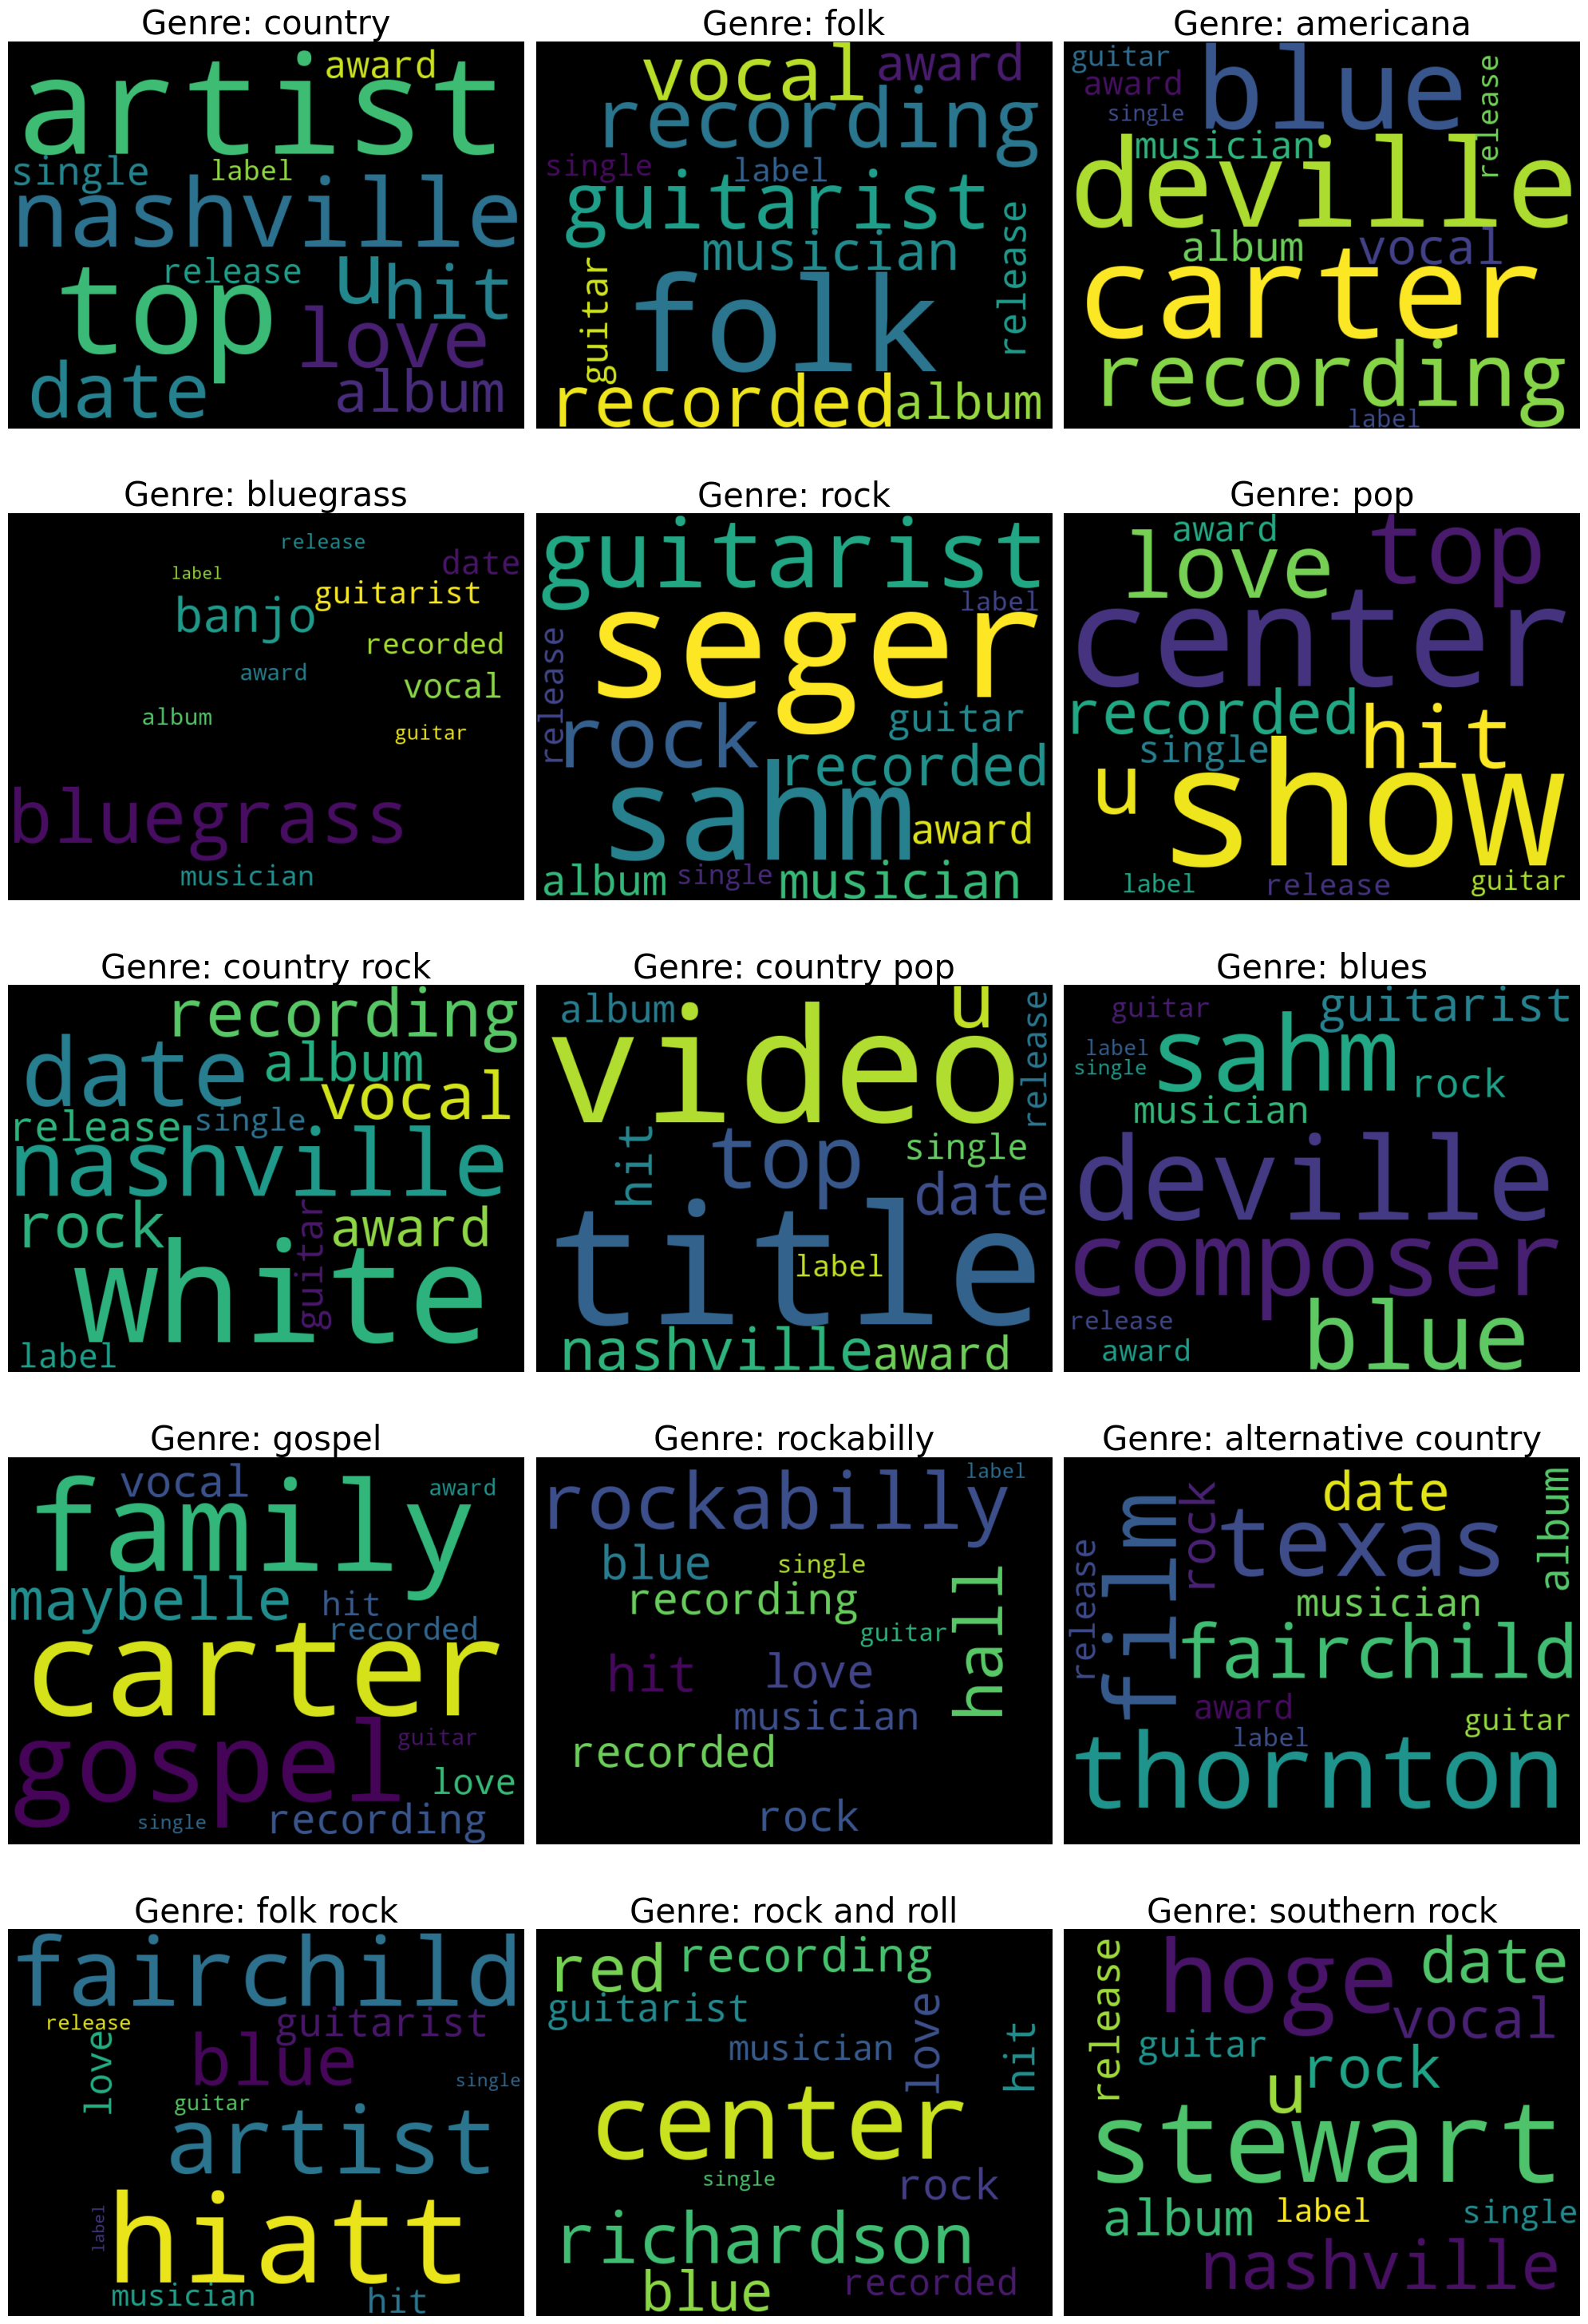

In [141]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'first', 'new', 'two', 'like', 'would', 'time',
    'music', 'album', 'song', 'songs', 'artist', 'genre', 'year',
    'years', 'chart', 'billboard', 'released', 'singer', 'group',
    'may', 'could', 'including', 'many', 'well', 'known',
    'even', 'although', 'however', 'make', 'made', 'way', 'get', 'got', 'take',
    'taken', 'see', 'used', 'say', 'another', 'still', 'since', 'come', 'second',
    'became', 'member', 'members', 'performed', 'career', 'born',
    'known', 'popular', 'best'
])

# Prepare the TF-IDF data for word clouds
genre_tfidf_dict = {}
for genre in genre_tfidf:
    tfidf_scores = dict(genre_tfidf[genre])
    genre_tfidf_dict[genre] = tfidf_scores

# Determine the number of genres to display
top_genres = top_15_genres  # This should be the list of your top 15 genres

# Set up the subplot grid dimensions
num_genres = len(top_genres)
cols = 3  # Adjust the number of columns as needed
rows = (num_genres + cols - 1) // cols

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 6 * rows))

# Flatten axes array for easy iteration
if num_genres == 1:
    axes = [axes]  # Ensure axes is iterable when there's only one subplot
else:
    axes = axes.flatten()

# Generate and plot the word clouds
for idx, genre in enumerate(top_genres):
    tfidf_scores = genre_tfidf_dict.get(genre, {})
    # Exclude words with zero or negative TF-IDF scores
    tfidf_scores = {word: score for word, score in tfidf_scores.items() if score > 0}
    wordcloud = WordCloud(
        width=800,
        height=600,
        background_color='black',
        stopwords=custom_stopwords,
        colormap='viridis'
    ).generate_from_frequencies(tfidf_scores)
    
    # Plot the word cloud in the corresponding subplot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f"Genre: {genre}", fontsize=30)
    
# Remove any empty subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


Communities

In [135]:
def normalize_artist_name(name):
    return name.strip().lower().replace('_', ' ').replace('-', ' ')

# Normalize artist names in artist_texts
normalized_artist_texts = {}
for artist_name, text in artist_texts.items():
    normalized_name = normalize_artist_name(artist_name)
    normalized_artist_texts[normalized_name] = text

# Normalize artist names in structural communities
normalized_structural_communities = {}
for community_id, artists in structural_communities.items():
    normalized_artists = [normalize_artist_name(artist) for artist in artists]
    normalized_structural_communities[community_id] = normalized_artists

    # Function to preprocess text
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [
        token.lower()
        for token in tokens
        if token.isalpha()
    ]
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words
    ]
    return tokens  # Return tokens for TF calculation

# Aggregate texts and compute TF for each community
community_tf = {}

for community_id, artists in normalized_structural_communities.items():
    all_tokens = []
    for artist in artists:
        text = normalized_artist_texts.get(artist, "")
        if text:
            tokens = preprocess_text(text)
            all_tokens.extend(tokens)
        else:
            print(f"Warning: Text not found for artist '{artist}' in community '{community_id}'")
    # Compute term frequencies
    word_counts = Counter(all_tokens)
    community_tf[community_id] = word_counts  # Stores Counter objects

import math
from collections import defaultdict

# Total number of documents (communities)
N = len(community_tf)

# Calculate Document Frequencies (DF)
word_df = defaultdict(int)

# Create a set of all unique words
all_words = set()
for word_counts in community_tf.values():
    all_words.update(word_counts.keys())

for word in all_words:
    df = sum(1 for community in community_tf if word in community_tf[community])
    word_df[word] = df

# Calculate IDF for each word
word_idf = {}
for word, df in word_df.items():
    idf = math.log(N / df)
    word_idf[word] = idf

# Calculate TF-IDF for each word in each community
community_tfidf = {}

for community_id, tf_counts in community_tf.items():
    tfidf_scores = {}
    for word, tf in tf_counts.items():
        idf = word_idf[word]
        tfidf = tf * idf
        tfidf_scores[word] = tfidf
    # Sort words by TF-IDF score in descending order
    sorted_tfidf = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    community_tfidf[community_id] = sorted_tfidf


top_n = 10

for community_id in sorted(community_tfidf.keys()):
    print(f"\nTop {top_n} TF-IDF words for community '{community_id}':")
    top_words = community_tfidf[community_id][:top_n]
    for word, score in top_words:
        print(f"  {word}: {score:.4f}")





Top 10 TF-IDF words for community '0':
  pritchett: 20.7944
  canyon: 8.6305
  canadian: 8.5460
  mcintosh: 7.6246
  lubig: 6.2383
  longstaffe: 6.2383
  farrell: 4.7000
  association: 4.6736
  nova: 4.2300
  merrett: 4.1589

Top 10 TF-IDF words for community '1':
  wynette: 257.1576
  center: 246.6325
  rca: 246.2819
  eastwood: 235.6700
  guitarist: 211.7340
  autry: 208.9166
  decca: 202.3990
  mandrell: 201.7058
  como: 199.6264
  darin: 194.2042

Top 10 TF-IDF words for community '2':
  tour: 746.8227
  bieber: 603.0380
  timberlake: 361.8228
  bergling: 336.8695
  lovato: 288.3638
  beyoncé: 272.4068
  mcgraw: 242.6015
  mccreery: 234.9769
  sheeran: 229.5140
  week: 227.8442

Top 10 TF-IDF words for community '3':
  tweedy: 434.6033
  bluegrass: 354.1366
  guitarist: 315.5872
  tour: 311.5597
  folk: 308.9705
  grammy: 281.3531
  ronstadt: 268.9411
  wilco: 259.2370
  guitar: 214.5849
  scruggs: 213.4893

Top 10 TF-IDF words for community '4':
  panettiere: 113.6761
  benanti: 

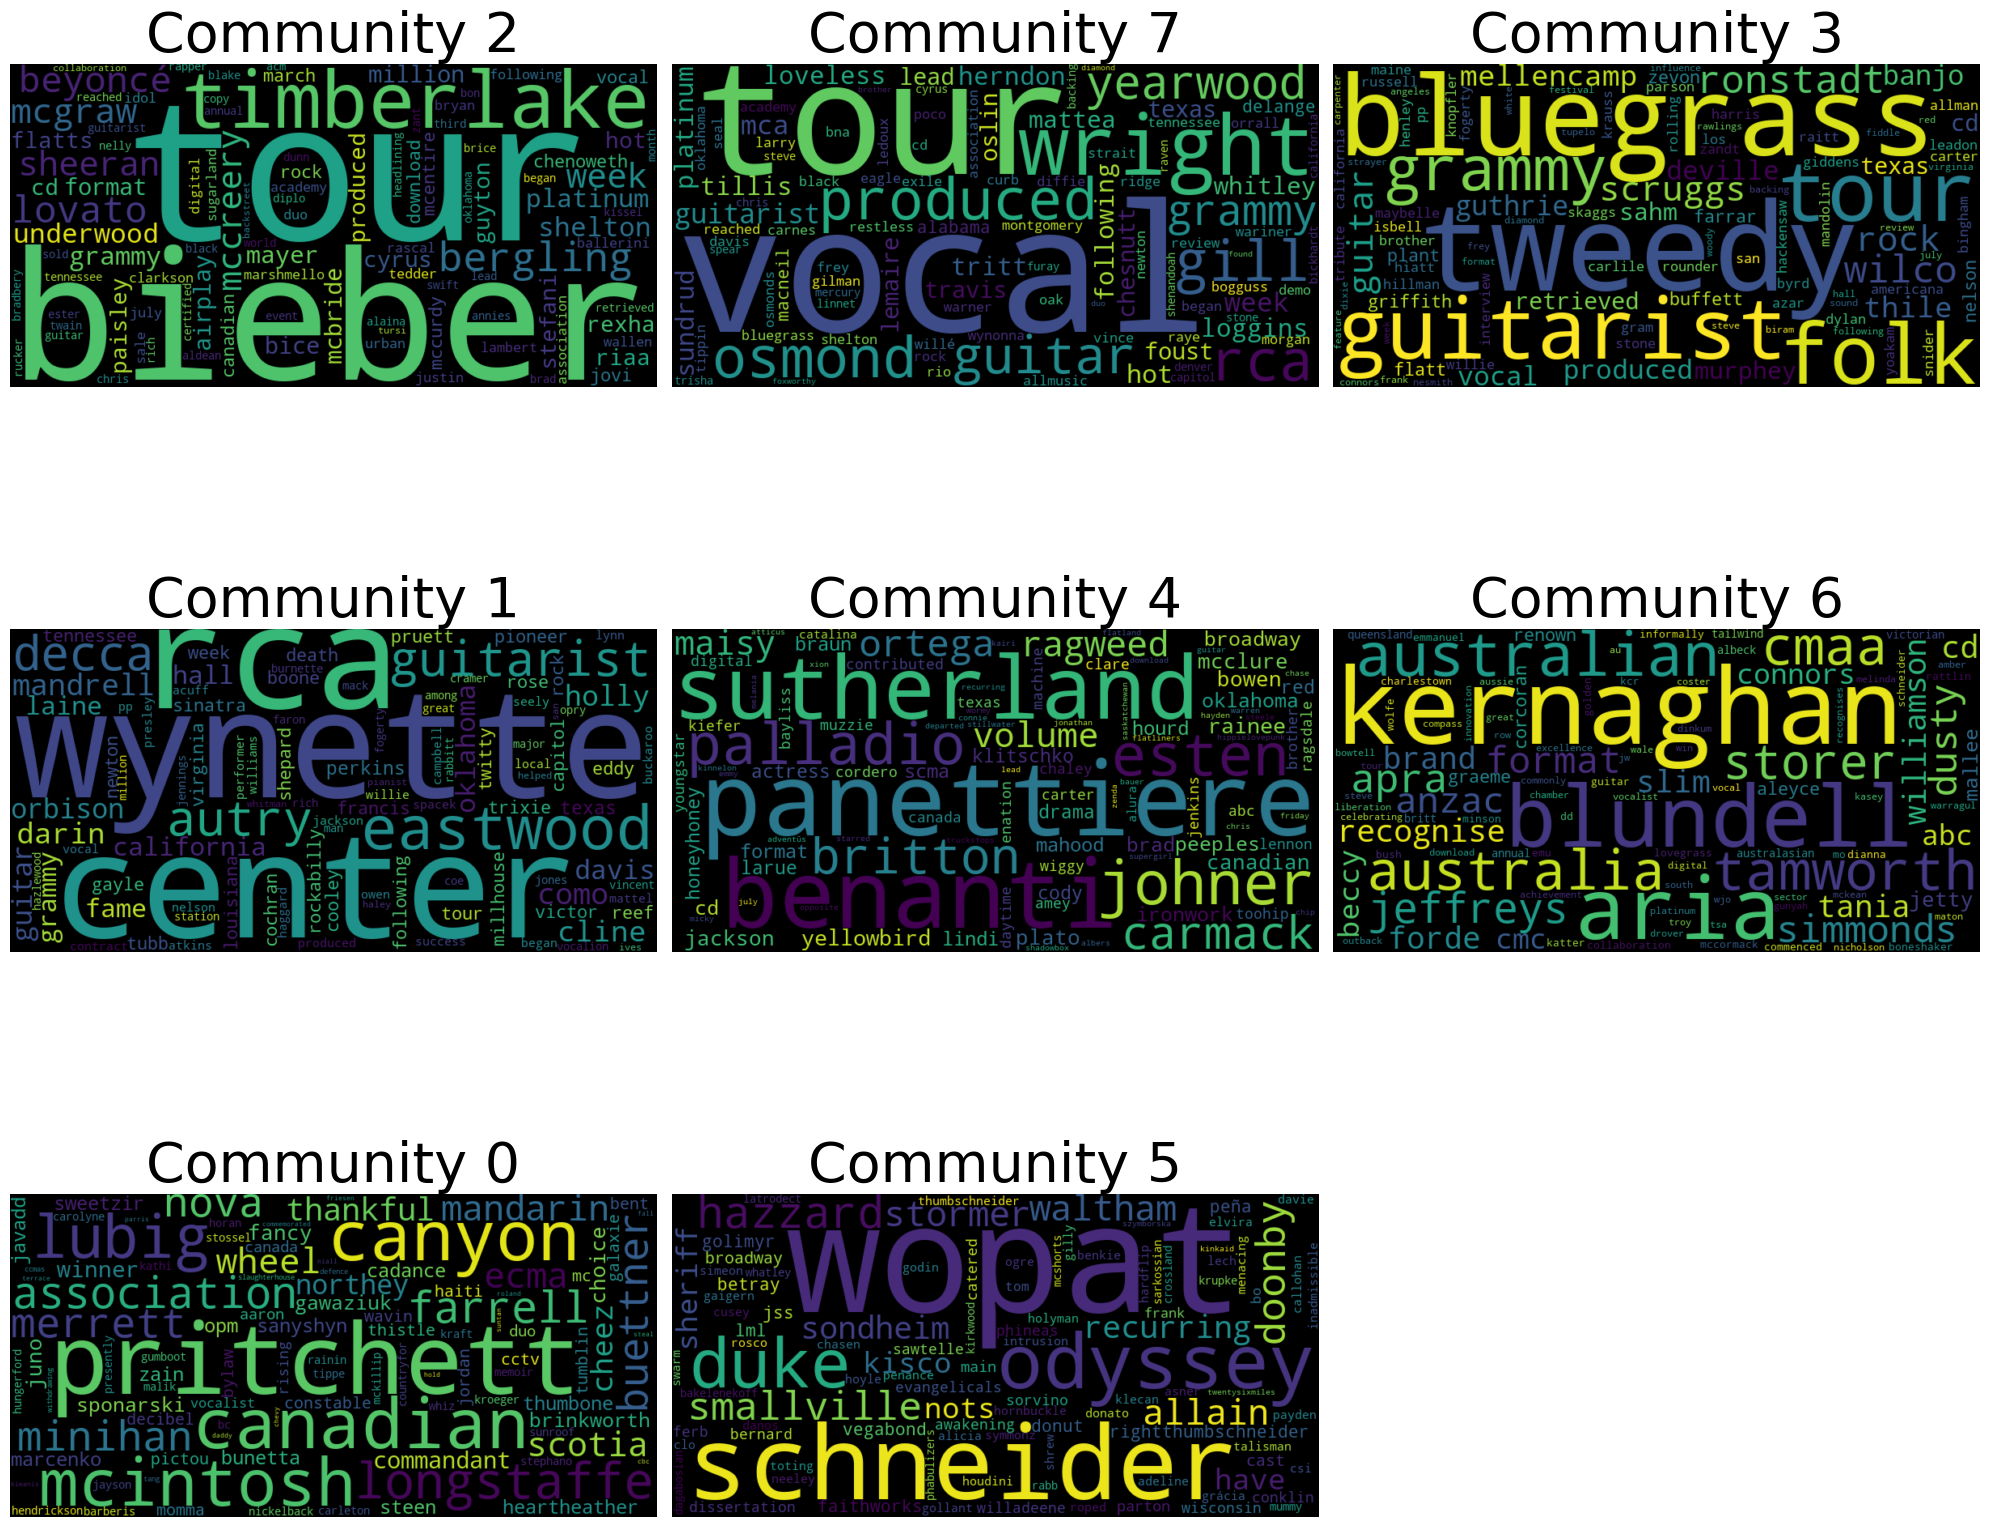

In [142]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'one', 'said', 'also', 'first', 'new', 'two', 'like', 'would', 'time', 
    'music', 'album', 'band', 'song', 'songs', 'artist', 'genre', 'year', 
    'years', 'chart', 'billboard', 'released', 'singer', 'group', 'american', 
    'united', 'states', 'may', 'could', 'including', 'many', 'well', 'known',
    'even', 'although', 'however', 'make', 'made', 'way', 'get', 'got', 'take',
    'taken', 'see', 'used', 'say', 'another', 'still', 'since', 'come', 'second',
    'became', 'member', 'members', 'performed', 'performance', 'career', 'born',
    'live', 'known', 'popular', 'best'
])

# Prepare the TF-IDF data for word clouds
community_tfidf_dict = {}
for community_id in community_tfidf:
    tfidf_scores = dict(community_tfidf[community_id])
    community_tfidf_dict[community_id] = tfidf_scores

# Determine the number of communities to display
community_sizes = {community_id: len(artists) for community_id, artists in normalized_structural_communities.items()}
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
top_N = 10  # Adjust as needed
top_communities = [community_id for community_id, size in sorted_communities[:top_N]]

# Set up the subplot grid dimensions
num_communities = len(top_communities)
cols = 3  # Adjust the number of columns as needed
rows = (num_communities + cols - 1) // cols

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 6 * rows))

# Flatten axes array for easy iteration
if num_communities == 1:
    axes = [axes]  # Ensure axes is iterable when there's only one subplot
else:
    axes = axes.flatten()

# Generate and plot the word clouds
for idx, community_id in enumerate(top_communities):
    tfidf_scores = community_tfidf_dict[community_id]
    # Exclude words with zero or negative TF-IDF scores
    tfidf_scores = {word: score for word, score in tfidf_scores.items() if score > 0}
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        stopwords=custom_stopwords,
        colormap='viridis',
        max_words=100
    ).generate_from_frequencies(tfidf_scores)
    
    # Plot the word cloud in the corresponding subplot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f"Community {community_id}", fontsize=40)
    
# Remove any empty subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()
